In [2]:
import pandas as pd
import numpy as np

In [3]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [4]:
df = pd.read_csv('monthly-us-auto-registration-tho.csv')

In [20]:
df.head()

,"Month;""Monthly U.S. auto registration (thousands) 1947 ? 1968"""
0,1947-01;209
1,1947-02;214
2,1947-03;265
3,1947-04;290
4,1947-05;287


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 1 columns):
Month;"Monthly U.S. auto registration (thousands) 1947 ? 1968"    264 non-null object
dtypes: object(1)
memory usage: 2.1+ KB


In [22]:
df.columns

Index(['Month;"Monthly U.S. auto registration (thousands) 1947 ? 1968"'], dtype='object')

In [23]:
df = df.rename({'Month;"Monthly U.S. auto registration (thousands) 1947 ? 1968"' : 'x'}, axis='columns')

In [24]:
df.columns

Index(['x'], dtype='object')

In [26]:
df.head()

,x
0,1947-01;209
1,1947-02;214
2,1947-03;265
3,1947-04;290
4,1947-05;287


In [27]:
df.x = df.x.str.split(';')

In [35]:
df['dat'] = df.x.apply(lambda x: x[0])

In [37]:
df['dat'].head()

0    1947-01
1    1947-02
2    1947-03
3    1947-04
4    1947-05
Name: dat, dtype: object

In [38]:
df['val'] = df.x.apply(lambda x: x[1])

In [40]:
df.drop('x', inplace=True, axis=1)

In [41]:
df.head()

,dat,val
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [42]:
df.dat = pd.to_datetime(df.dat)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
dat    264 non-null datetime64[ns]
val    264 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 4.2+ KB


In [46]:
df.head()

,dat,val
0,1947-01-01,209
1,1947-02-01,214
2,1947-03-01,265
3,1947-04-01,290
4,1947-05-01,287


In [51]:
df['val'] = df['val'].astype('int')

In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


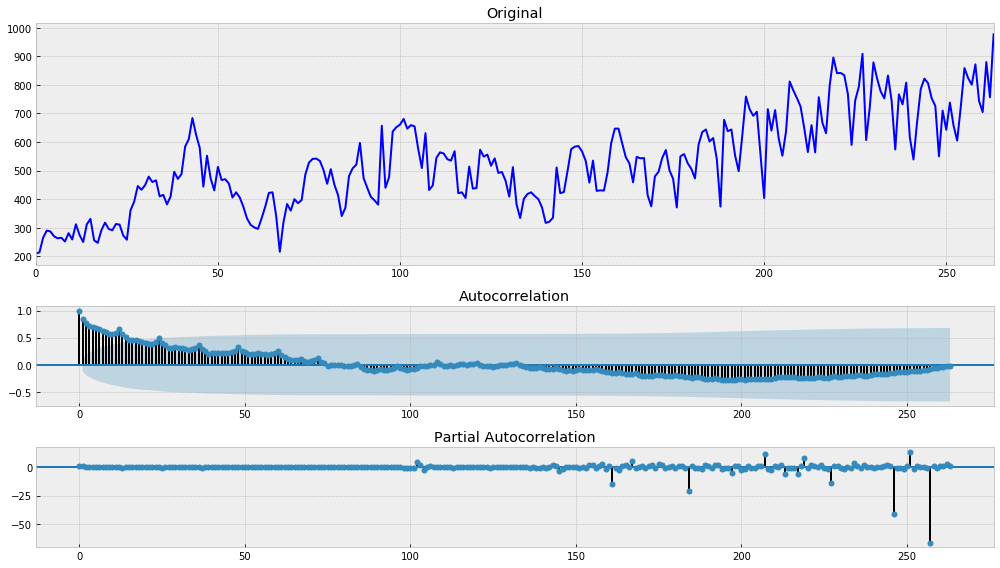

In [52]:
tsplot(df['val'])

Тест Дики-Фуллера не позволяет нам отклонить гипотезу о нестационарности ряда. График оригинального ряда явно демонстрирует наличие тренда.Коррелограммытакже указывают на нестационарность ряда. Попробуем сначала убрать изменение дисперсии при помощи Бокса-Кокса.

In [67]:
series = boxcox(df['val'], 0.001)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941107
p-value                          0.312977
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


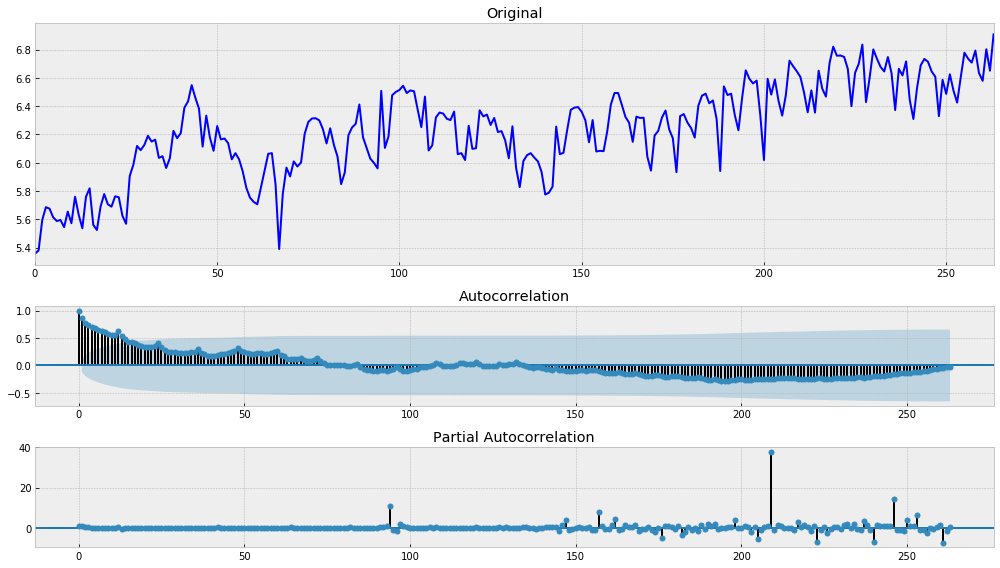

In [68]:
tsplot(series)

Стало лучше, но тест Дики-Фуллера еще также не позволяет отвергнуть нулевую гипотезу + по графику коррелограмм видно наличие тренда и сезонность.Используем дифференирование для устранения тренда.

In [69]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                  -4.362332
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


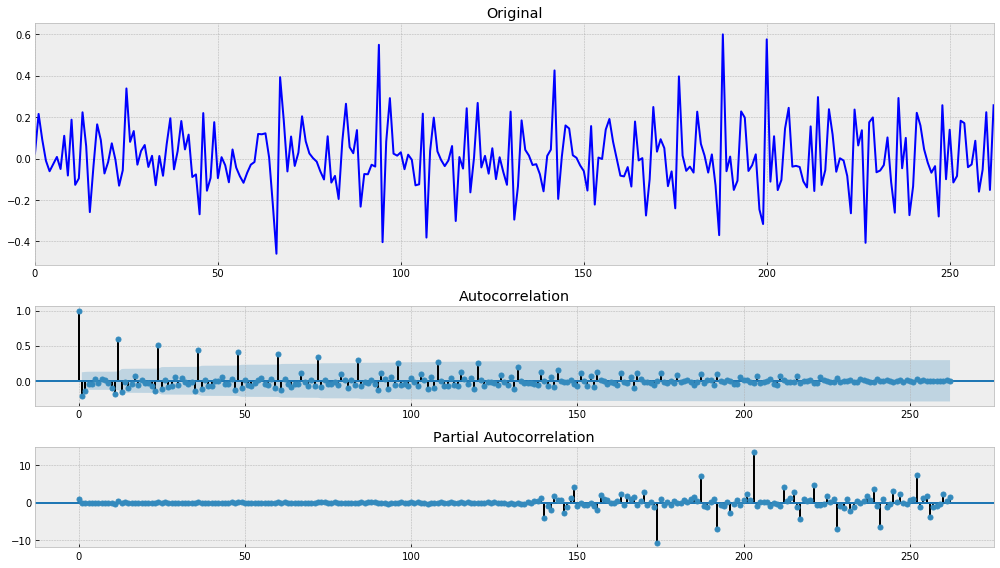

In [70]:
tsplot(series)

Уже на этом этапе по тесту можем видеть, что ряд стационарен, однако, график коррелограммы свидетельствует о наличие сезонности, попробуем убрать ее и посмотреть, что получится.

In [71]:
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528563e+00
p-value                        1.000244e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


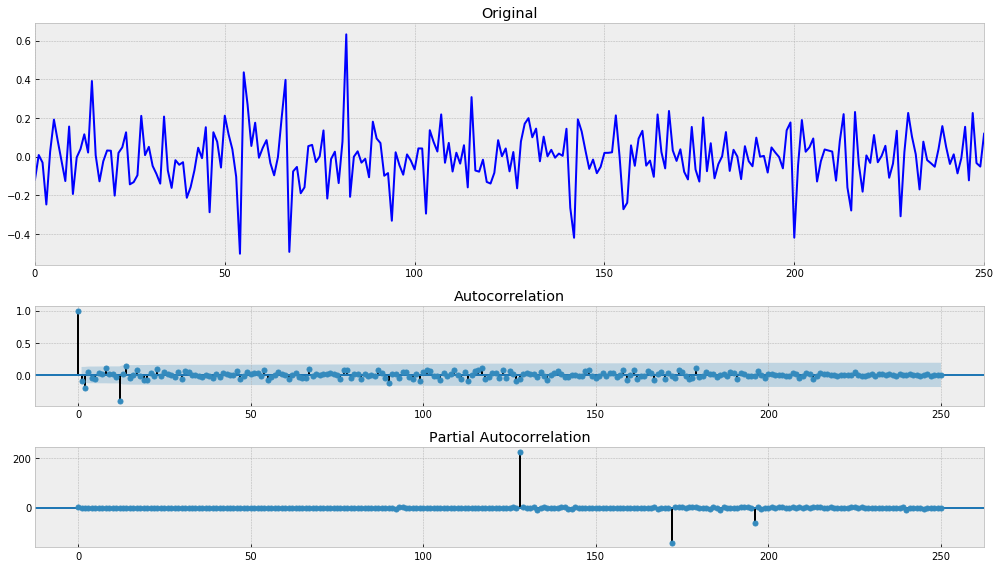

In [72]:
tsplot(series)

Теперь как тест, так и графики коррелограмм свидетельсвтуют о том, что ряд стал стационарным.

In [189]:
df = pd.read_csv('weekly-closings-of-the-dowjones-.csv')

In [190]:
df.head()

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [191]:
df = df.rename({'Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974' : 'x'},axis = 'columns')

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
Week    162 non-null object
x       162 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


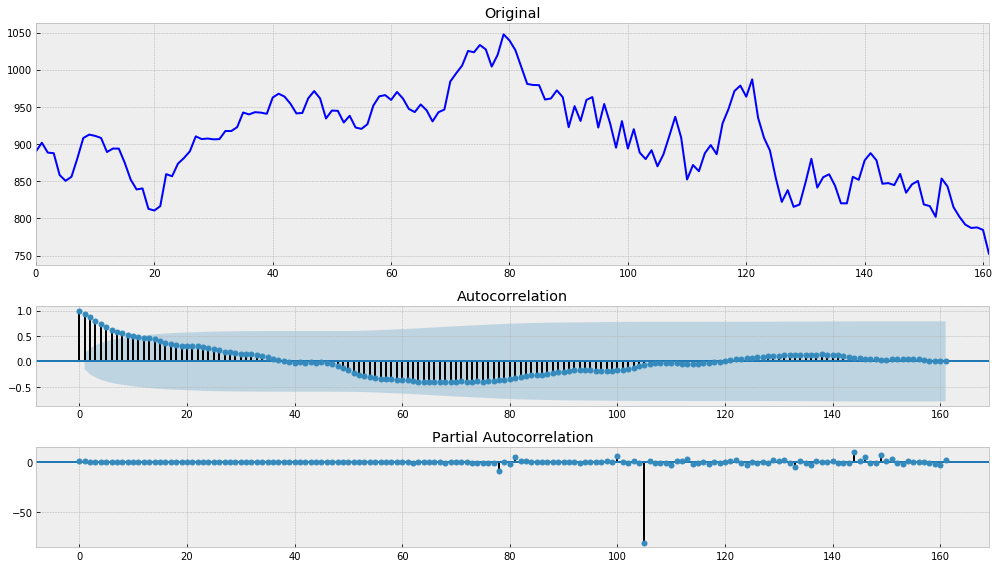

In [193]:
tsplot(df['x'])

Тест и графики свидетельствуют о нестационарности ряда. Можно видеть наличие тренда и сезоннасти. Повторим предыдущий проесс, чтобы сделать ряд стационарным.

In [194]:
series, lam = boxcox(df['x'])

In [195]:
lam

1.1328301649870167

Так как с нулевой лямбдой бокс кокс не давал улучшений, поставила этот параметр None, чтобы было автоматически найдено значение, максимизирующее функцию логарифма правдоподобия

Results of Dickey-Fuller Test:
Test Statistic                  -1.327773
p-value                          0.616372
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


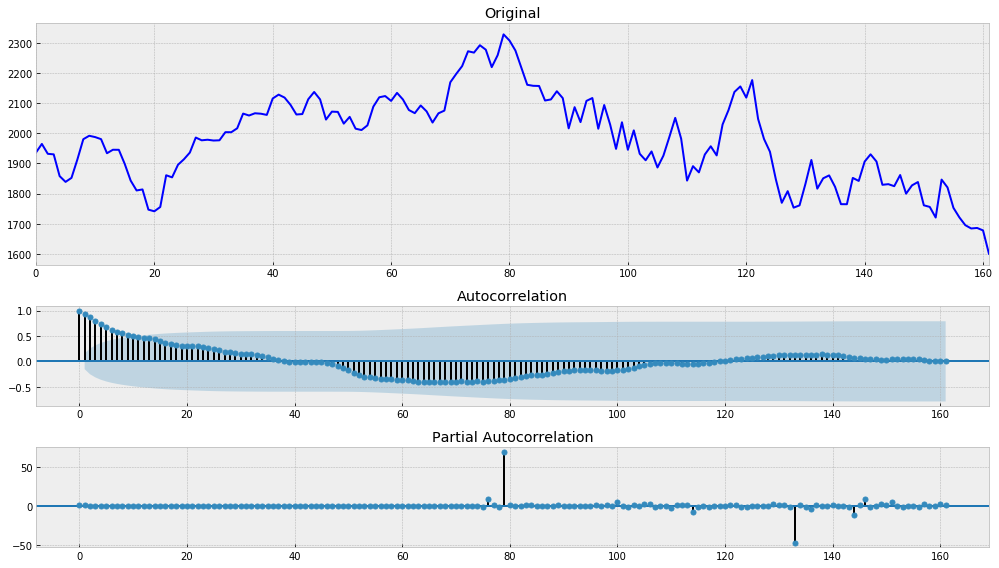

In [196]:
tsplot(series)

Наш ряд все также нестационарен, продолжим исследование.

In [197]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.302750e+01
p-value                        2.382691e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


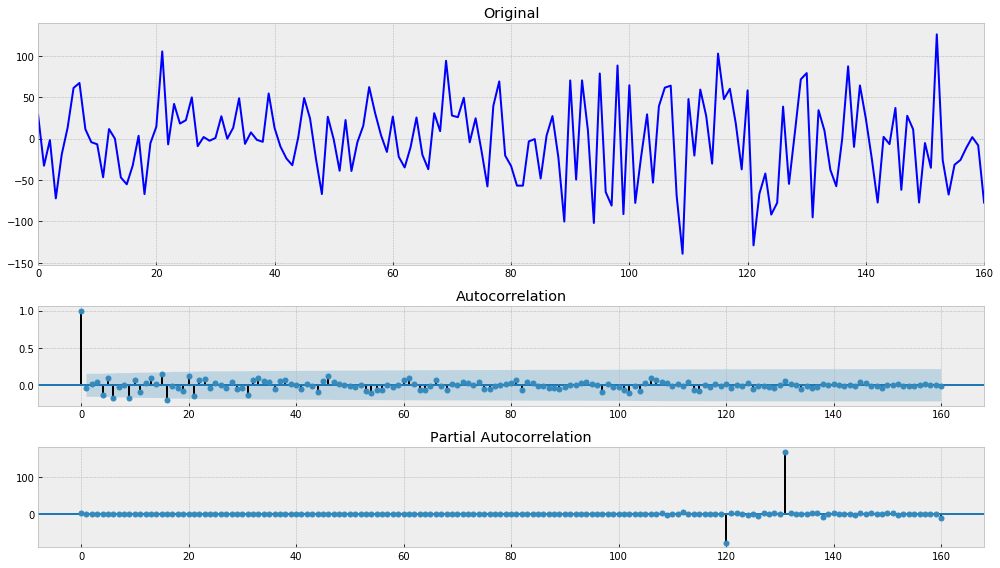

In [137]:
tsplot(series)

Дифференцирование позволило сделать ряд полностью стационарным. По тесту и графикам видно, что больше делать каких либо преобразований необязательно.

# Приближение к MA (скользящему среднему)

Используем Weekly closings of the Dow-Jones 

нестационарный ряд

### EMA (exponential MA)

Используем EMA так как хотим учитывать всю историю изменения индекса, при этом также хотелось бы, чтобы свмые недавние значения влияли сильнее.

In [128]:
ser_non_stat = pd.Series(df['x'])

In [126]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

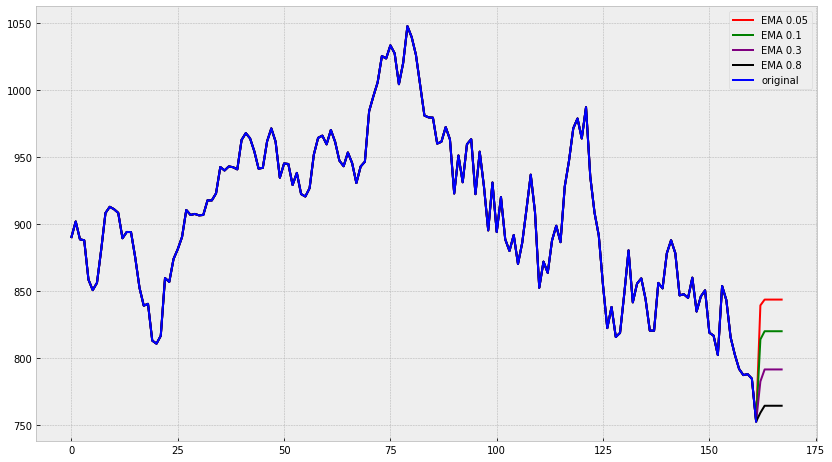

In [127]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(ser_non_stat, alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(ser_non_stat, color='blue',label='original')
    plt.legend()

Остановимся на альфе 0.8. Сразу можно отметить уже по графику, что данная модель оказалась не очень хороша для предсказания индекса, так как плохо предсказывает возможную направленность будущих изменений, задавая только некую среднюю тенденцию. Особенность данных в том, что они достаточно вариабельны, и предсказывать их константой точно не подходит.

In [23]:
len(ser_non_stat)

162

In [24]:
train, val = ser_non_stat[:80], ser_non_stat[80:]

In [52]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split = pd.Series(train_split)
        result,_ = exponential_moving_average(train_split,  alpha, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [53]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [54]:
opt = minimize(mse_cross_val, x0=[0], method="L-BFGS-B", bounds=[(0,1)])

In [56]:
alpha_opt= opt.x
print(opt)

      fun: 143.5
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-41.99999921])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])


In [57]:
alpha_opt

array([1.])

### DEMA

Чтобы учесть изменчивость в данных и тренд воспользумеся двойным экспоненциальным сглаживанием.

In [182]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    y = series.iloc[-1]
    for n in range(1, n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [149]:
def plot_dema(alpha, beta):
    dema , _= double_ema_with_preds(ser_non_stat, alpha, beta,20)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(dema, color='blue',label='original')
        plt.plot(dema.iloc[-20:], color='red',label='original')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

Из-за того, что последние значения графика пошли вниз, наша модель без определенной регулировки также стремительно уходит вниз. Отлавливая тренд последних значений

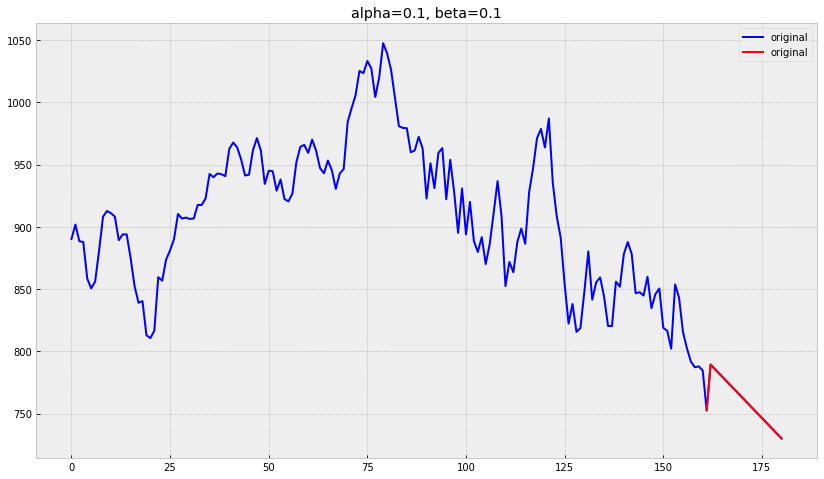

In [150]:
plot_dema(0.1, 0.1)

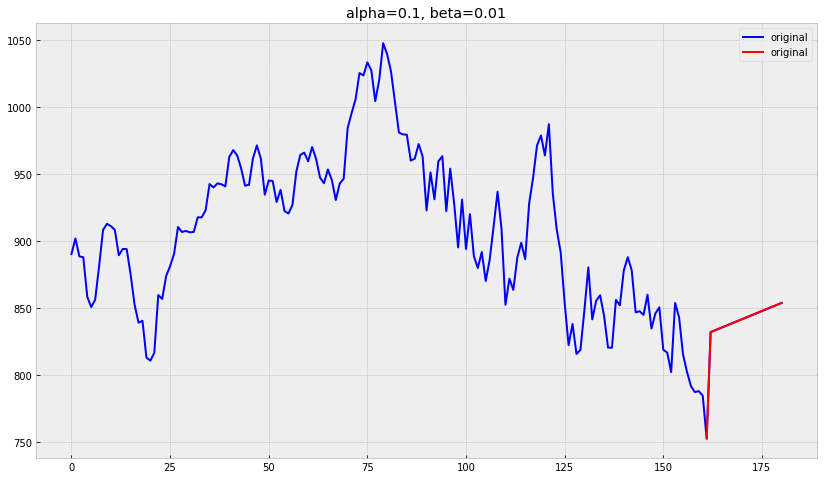

In [151]:
plot_dema(0.1, 0.01)

Если уменьшить влияние тренда, график пойдет вверх, но значения также очивидно не подходят под описание реальных данных.

Попробуем построить DEMA используя стационарный ряд

In [202]:
series_stat = pd.Series(series.copy())

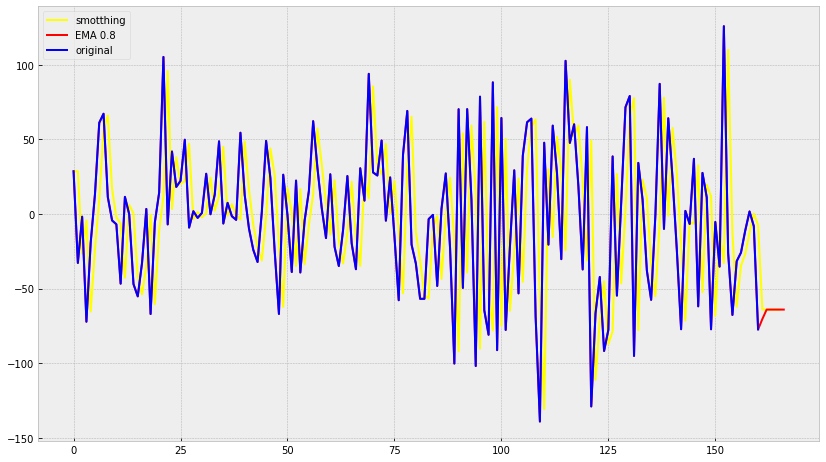

In [229]:

colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))

    ser, result = exponential_moving_average(series_stat,0.9, 5)
    plt.plot(result, color='yellow',label='smotthing')
    plt.plot(ser, color='red', linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series_stat, color='blue',label='original')
    plt.legend()

In [216]:
def plot_dema(alpha, beta):
    dema , result = double_ema_with_preds(series_stat, alpha, beta,20)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_stat, color='blue',label='original')
        plt.plot(result, color='yellow',label='smotthing')
        plt.plot(dema.iloc[-20:], color='red',label='original')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

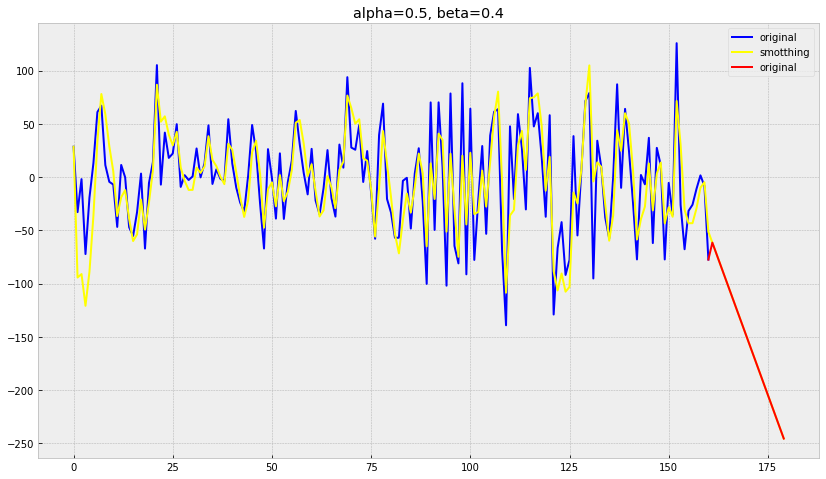

In [225]:
plot_dema(0.5, 0.4)

При рассмотрении графиков адекватнее всего смотрится взвешенное среднее. Оно неплохо апроксимирует существующие значения и старается сделать какое то среднее предсказание. Экспоненциальное сглаживание подхватывает послдний тренд и неуклонно следует ему. Для специфики данной модели это скорее всего еще хуже, чем просто попытаться предсказать какое то среднее возможное значение, как это получилось в взвешенном среднем.